# Time Series Forecasting

Author: Charles Liu
This notebook includes the data preprocessing, model training, validation and testing.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
ticker = 'AYF'

## Prepare data

### Select a ticker and read the data to data frame

In [2]:
# Read dataframe
from pricedata import read_stock_data, read_dates
df_raw = read_stock_data(ticker)
df_raw.shape

(463, 5)

In [3]:
df_raw.head(n=4)

,open,high,low,close,volume
date,,,,,
2015-01-02,6.33,6.33,6.33,6.33,150
2015-01-08,6.41,6.42,6.41,6.42,7000
2015-01-09,6.42,6.42,6.42,6.42,4000
2015-01-12,6.42,6.42,6.42,6.42,5000


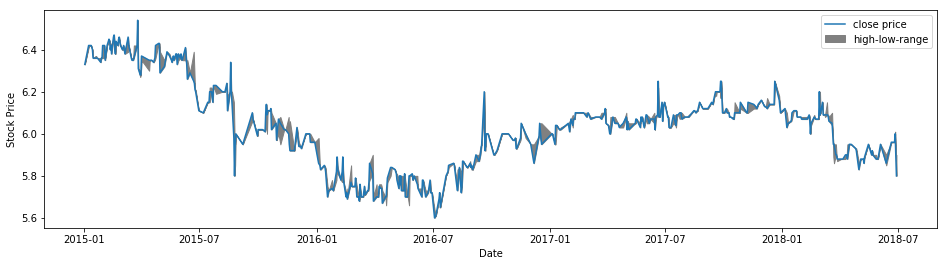

In [4]:
# Visualize the data. We see the the variance of the prices if much smaller than the variance across time
df = df_raw
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

## Prepare the data
1. Handling missing data.

 Time interpolation

In [30]:
# Read full trading dates and create a dataframe with full trading dates. 
dates = read_dates()
if len(dates) > len(df_raw):
    df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
    df_full.loc[df_raw.index] = df_raw.astype(float)
df_full.shape

(883, 5)

In [27]:
df_full.head()

,open,high,low,close,volume
2015-01-02,6.33,6.33,6.33,6.33,150.0
2015-01-05,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN
2015-01-08,6.41,6.42,6.41,6.42,7000.0


In [31]:
from helpers import time_interpolate
if df_full.isna().sum().sum() > 0:
    df_full = df_full.interpolate(method='linear')
df_full.head()

,open,high,low,close,volume
2015-01-02,6.33,6.3300,6.33,6.3300,150.0
2015-01-05,6.35,6.3525,6.35,6.3525,1862.5
2015-01-06,6.37,6.3750,6.37,6.3750,3575.0
2015-01-07,6.39,6.3975,6.39,6.3975,5287.5
2015-01-08,6.41,6.4200,6.41,6.4200,7000.0


2. Scaling

In this model, All five columns will be used as the input features. Because they have different scales, particularly, the the scale of volume data is much larger that prices.
So We need to scale of the data.

In [33]:
from sklearn import preprocessing
X = preprocessing.scale(df.values)
df_scaled = pd.DataFrame(index=df_full.index, data=X, columns=df_full.columns)
df_scaled.head()

,open,high,low,close,volume
2015-01-02,1.561793,1.518154,1.603001,1.559066,-1.112169
2015-01-05,1.669048,1.638070,1.709262,1.677741,-0.656836
2015-01-06,1.776304,1.757986,1.815523,1.796416,-0.201503
2015-01-07,1.883559,1.877902,1.921784,1.915091,0.253830
2015-01-08,1.990814,1.997818,2.028045,2.033765,0.709164


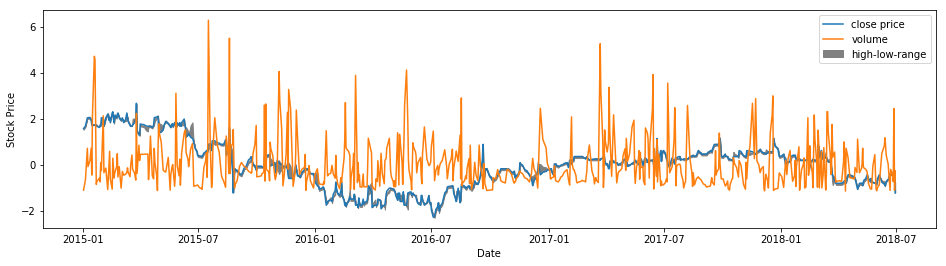

In [38]:
df = df_scaled
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.plot(df.index, df['volume'], label='volume')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Prepare the training, validation and test data

In [40]:
from helpers import batch_generator
lookback = 5
delay = 1
iterator = batch_generator(df_scaled, hop='5D')

### Feature Selection
Here are about my feature selection.
   1. The Open, high, low and high prices and the trading volume are used.
   2. Look back time: 5 days.

### Split the data to training, validation and test sets.

In [12]:
from helpers import batch_generator
import numpy as np